# (static) Biot equation

In this tutorial we present how to solve the (static) Biot equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unknown is the displacement $u$, the flux $q$ and the pressure $p$.

Let $\Omega$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$\lambda$ Lamé constant and $\mu$ the Kirchhoff modulus, $K$ the permeability of the porous medium and $s_0$ its storativity, and $\alpha$ the Biot-Willis coefficient fot the coupling between the two models.
We want to solve the following problem: find $({u}, {q}, p)$ such that
$$
    \begin{aligned}
         & \nabla \cdot [2 \mu {\varepsilon}({u}) + \lambda \nabla \cdot u I
         - \alpha p {I}] = -{b}   \\
         & \mu{q} + {K}\nabla p = {0}                        \\
         & \partial_t (s_0 p + \alpha \nabla \cdot {u}) +
        \nabla \cdot {q} = \psi
    \end{aligned}
    \quad \text{in } \Omega.
$$
with $\varepsilon$ the symmetric gradient and $b$ a body force. The stress tensor, which can be post-processed from $u$, is given by
$$
    \sigma = 2 \mu \varepsilon(u) + \lambda \nabla \cdot u I - \alpha p I
$$

In particular, we consider only the spatial structure of the previous problem by doing only one time step. We call the latter $\Delta t$ and write the discrete problem as
$$
    \begin{bmatrix}
        A & 0 & -\alpha C^\top \\
        0 & \Delta t M_q & - \Delta t B^\top \\
        \alpha C & \Delta t B & s_0 M_p
    \end{bmatrix}
    \begin{bmatrix}
        u \\ q \\ p
    \end{bmatrix}
    =
    \begin{bmatrix}
        b \\ 0 \\ \psi
    \end{bmatrix}
$$
where $A$ is the stiffness matrix associated with the elatic problem, $C$ is the coupling between the two physics, $M_q$ is the mass matrix associated to the flux variable, $B$ is the divergence matrix for the flow problem, and $M_p$ is the mass matrix associated with the pressure. All the aforementioned matrices are properly scaled by their physical parameters if not explicitly written. The second row has been multiply by $\Delta t$ to preserve the skew-symmetry of the problem.

## Exercise 1: footing problem

A footing problem is when a force is impose on the top compressing the body and the bottom is fixed. In this case we assume that the force is applied on the central portion of the top boundary.

For this test case we set $\Omega = [0, 3] \times [0, 1]$, $b = 0$, and the following boundary conditions:
$$ 
\begin{aligned}
    &u = 0 &&\text{ and }&& \nu \cdot q = 0 &&\text{ on } \partial \Omega  \setminus \partial_{top} \Omega
\\
&\nu \cdot \sigma = 0 &&\text{ and }&& p = 0 &&\text{ on } \partial_{top} \Omega \setminus \partial_s \Omega
\\
&\nu \cdot \sigma = [0, -1e-3]^\top &&\text{ and }&& p = 0 &&\text{ on }\partial_s \Omega 
\end{aligned}
$$
where $\partial_{s} \Omega = [1, 2] \times \{1\}$.

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [ ]:
import os
import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

We create now the grid, since we use a vector Lagrangian of order 1 for ${u}$ and Raivar-Thomas for the flux $q$, we are restricted to simplices. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 3d.

In [2]:
mesh_size = 0.1
delta_t = 0.1
dim = 2

pts = np.array([[0, 3, 3, 2, 1, 0], [0, 0, 1, 1, 1, 1]])
sd = pg.grid_from_boundary_pts(pts, mesh_size, as_mdg=False)
sd.compute_geometry()

With the following code we set the data and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [ ]:
key = "biot"

# the physical parameters of the problem, assumed constant
alpha = 1
s0 = 1

inv_perm = pp.SecondOrderTensor(np.ones(sd.num_cells))
param = {pg.SECOND_ORDER_TENSOR: inv_perm, pg.LAME_LAMBDA: 1, pg.LAME_MU: 0.5}
data = pp.initialize_data({}, key, param)

# selection of the boundary conditions
bd_q = sd.tags["domain_boundary_faces"]
bd_q[np.isclose(sd.face_centers[1, :], 1)] = False

bd_u = sd.tags["domain_boundary_nodes"]
bd_u[np.isclose(sd.nodes[1, :], 1)] = False
bd_u = np.hstack([bd_u] * dim)

top_s = np.logical_and.reduce(
    (
        np.isclose(sd.face_centers[1, :], 1),
        sd.face_centers[0, :] > 1,
        sd.face_centers[0, :] < 2,
    )
)

fun = lambda _: np.array([0, -1e-3])

Once the data are assigned to the grid, we construct the matrices. Once the latter is created, we also construct the right-hand side containing the boundary conditions.

In [4]:
# definition of the discretizations
vec_p1 = pg.VecLagrange1(key)
p0 = pg.PwConstants(key)
rt0 = pg.RT0(key)

# construction of the block matrices
mass_q = rt0.assemble_mass_matrix(sd)
mass_p = p0.assemble_mass_matrix(sd)
div_q = mass_p @ rt0.assemble_diff_matrix(sd)

div_u = mass_p @ vec_p1.assemble_div_matrix(sd)
stiff_u = vec_p1.assemble_stiff_matrix(sd, data)

b = vec_p1.assemble_nat_bc(sd, fun, top_s)

# construction of the global problem
spp = sps.block_array(
    [
        [stiff_u, None, -alpha * div_u.T],
        [None, delta_t * mass_q, -delta_t * div_q.T],
        [alpha * div_u, delta_t * div_q, s0 * mass_p],
    ],
    format="csc",
)

# regroup of the right-hand side
bd = np.hstack((bd_u, bd_q, np.zeros(sd.num_cells, dtype=bool)))
rhs = np.hstack((b, np.zeros(sd.num_cells + sd.num_faces)))

# dofs for the different variables
dof_u = sd.num_nodes * dim
dof_q = sd.num_faces
dof_p = sd.num_cells
dofs = np.cumsum([dof_u, dof_q, dof_p])

We need to solve the linear system, PyGeoN provides a framework for that. The actual imposition of essential boundary conditions (displacement boundary conditions) might change the symmetry of the global system, the class `pg.LinearSystem` preserves this structure by internally eliminating these degrees of freedom.

In [5]:
# NOTE: in case of the quasi static Biot model, the temporal for loop should be placed
# around the next lines of code with proper update of the right-hand side depending
# on the solution at the previous time step

# solution of the problem
ls = pg.LinearSystem(spp, rhs)
ls.flag_ess_bc(bd, np.zeros_like(bd))
x = ls.solve()

# split of the solution from the vector x
u, q, p = np.split(x, dofs[:-1])

We post-process now the stress tensor, one `sd.dim` x `sd.dim` tensor per cell.

In [6]:
cell_sigma = vec_p1.compute_stress(sd, u, data)

# split the tensor in each component for the exporting
cell_sigma_xx = cell_sigma[:, 0, 0]
cell_sigma_xy = cell_sigma[:, 0, 1]
cell_sigma_yy = cell_sigma[:, 1, 1]

Since the computed $u$ is a vector per peak of the grid, for visualization purposes we project the displacement in each cell center as vector. Similarly for the flow field $q$. We finally export the solution to be visualized by [ParaView](https://www.paraview.org/).

In [7]:
# compute the cell displacement, one vector per cell
proj = vec_p1.eval_at_cell_centers(sd)
cell_u = proj @ u
# we need to add the z component for the exporting
cell_u = np.hstack((cell_u, np.zeros(sd.num_cells)))
cell_u = cell_u.reshape((3, -1))

# compute the cell flow, one vector per cell
proj_q = rt0.eval_at_cell_centers(sd)
cell_q = (proj_q @ q).reshape((3, -1))
cell_p = p0.eval_at_cell_centers(sd) @ p

# export the solution
folder_name = os.path.join(os.getcwd(), key)
file_name = "sol"

save = pp.Exporter(sd, file_name, folder_name=folder_name)
save.write_vtu(
    [
        ("cell_u", cell_u),
        ("cell_q", cell_q),
        ("cell_p", cell_p),
        ("cell_sigma_xx", cell_sigma_xx),
        ("cell_sigma_xy", cell_sigma_xy),
        ("cell_sigma_yy", cell_sigma_yy),
    ]
)

A representation of the computed solution is given below.

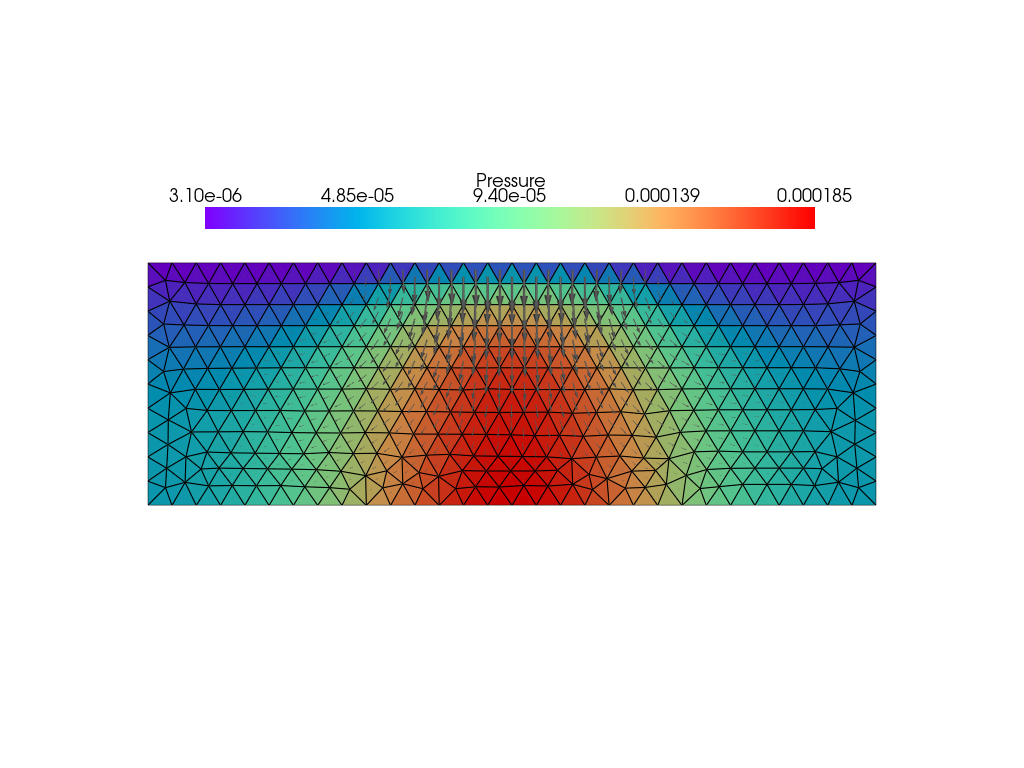

In [ ]:
# NBIGNORE
import pyvista as pv

file_vtu = os.path.join(folder_name, file_name + "_2.vtu")
mesh = pv.read(file_vtu)

plotter = pv.Plotter(off_screen=True, notebook=True)

# Glyphs scaled by magnitude
arrows = mesh.glyph(orient="cell_u", scale="cell_u", factor=400)
plotter.add_mesh(arrows, color="gray")

# Mesh colored by pressure
bar = {"title": "Pressure", "position_x": 0.2, "position_y": 0.7}
plotter.add_mesh(
    mesh, scalars="cell_p", cmap="rainbow", show_edges=True, scalar_bar_args=bar
)

# Show the result
plotter.view_xy()
plotter.enable_parallel_projection()
plotter.show(jupyter_backend="static")


In [9]:
# Consistency check
assert np.isclose(np.linalg.norm(u), 0.002533318590128781)
assert np.isclose(np.linalg.norm(q), 0.0005274749420365359)
assert np.isclose(np.linalg.norm(p), 1.1324566217655037e-05)